In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (Qobj, basis, mesolve)
from joblib import Parallel, delayed

%matplotlib inline

In [2]:
t_max = 50*np.pi
delta = 1
omega_max = 1
num_points = 500

times = np.linspace(0, t_max, num_points)

In [3]:
def omega(t, omega_max, t_max, sign=1):
    sigma = t_max/8
    return omega_max * np.exp(-(t - (t_max + sign*sigma)/2)**2 / (2*sigma**2))

def omega_12g(t, omega_max, t_max):
    return omega(t, omega_max, t_max)

def omega_23g(t, omega_max, t_max):
    return omega(t, omega_max, t_max, -1)

In [4]:
def solvePopulations(times, t_max, delta, omega_12g, omega_23g, omega_max):
    psi0 = basis(3, 0)

    if t_max == 0:
        return np.abs(np.array([psi0])) ** 2
    
    H0 = Qobj([[0, 0, 0], [0, delta, 0], [0, 0, 0]])
    H12 = Qobj([[0, -1, 0], [-1, 0, 0], [0, 0, 0]])
    H23 = Qobj([[0, 0, 0], [0, 0, -1], [0, -1, 0]])

    H = [H0, [H12, omega_12g(times, omega_max, t_max)], [H23, omega_23g(times, omega_max, t_max)]]

    result = mesolve(H, psi0, times)

    psi_t = np.array(result.states).reshape((len(times), 3))
    return np.abs(psi_t) ** 2

In [5]:
omega_12 = omega(times, omega_max, t_max)
omega_23 = omega(times, omega_max, t_max, -1)

In [6]:
def solveLastPopulation33(t_max, t_max_tot, num_points, delta, omega_12g, omega_23g, omega_max):
    times = np.linspace(0, t_max, int((t_max/t_max_tot)*num_points) + 1)
    return solvePopulations(times, t_max, delta, omega_12g, omega_23g, omega_max)[-1,2]

In [7]:
population = solvePopulations(times, t_max, delta, omega_12g, omega_23g, omega_max)
population_33_t_max = Parallel(n_jobs=8)(delayed(solveLastPopulation33)(t, t_max, num_points, delta, omega_12g, omega_23g, omega_max) for t in times)

In [8]:
population_int = solvePopulations(times, t_max, delta, omega_23g, omega_12g, omega_max)
population_33_t_max_int = Parallel(n_jobs=8)(delayed(solveLastPopulation33)(t, t_max, num_points, delta, omega_23g, omega_12g, omega_max) for t in times)

/home/pabolojo/miniconda3/envs/quantum/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 0, '$t_{max}[\\pi/\\Omega^{max}]$')

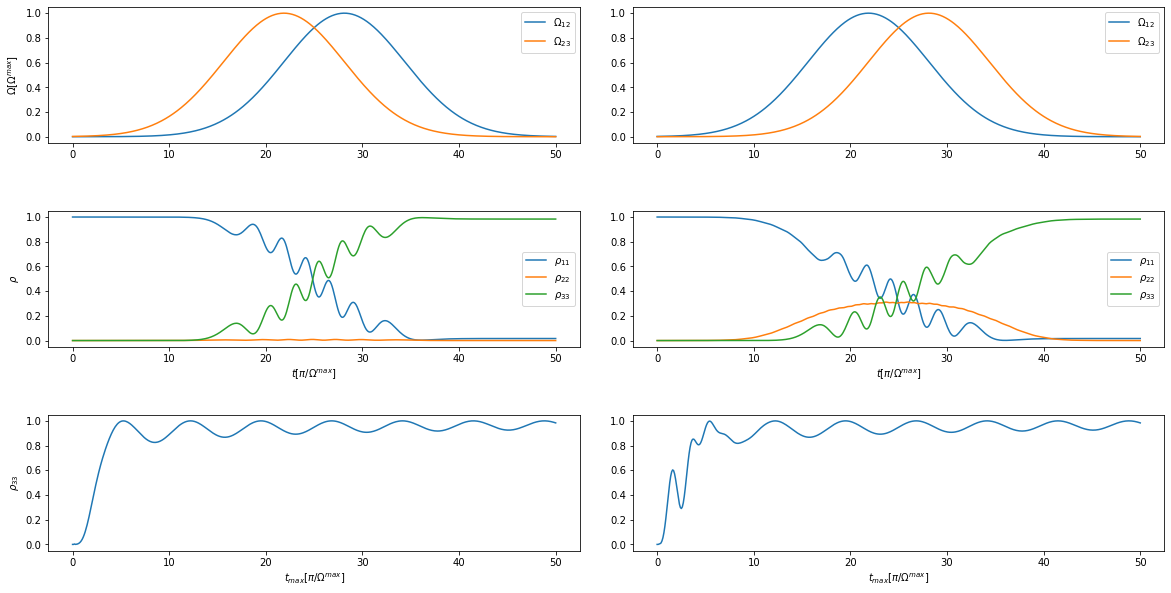

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(20,10))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

ax[0,0].plot(times/(np.pi/omega_max), omega_12/omega_max, label=r'$\Omega_{12}$')
ax[0,0].set_ylabel(r'$\Omega[\Omega^{max}]$')
ax[0,0].plot(times/(np.pi/omega_max), omega_23/omega_max, label=r'$\Omega_{23}$')
ax[0,0].legend()

ax[1,0].plot(times/(np.pi/omega_max), population[:,0], label=r'$\rho_{11}$')
ax[1,0].plot(times/(np.pi/omega_max), population[:,1], label=r'$\rho_{22}$')
ax[1,0].plot(times/(np.pi/omega_max), population[:,2], label=r'$\rho_{33}$')
ax[1,0].set_xlabel(r'$t[\pi/\Omega^{max}]$') 
ax[1,0].set_ylabel(r'$\rho$')
ax[1,0].legend()

ax[2,0].plot(times/(np.pi/omega_max), population_33_t_max)
ax[2,0].set_xlabel(r'$t_{max}[\pi/\Omega^{max}]$') 
ax[2,0].set_ylabel(r'$\rho_{33}$')

ax[0,1].plot(times/(np.pi/omega_max), omega_23/omega_max, label=r'$\Omega_{12}$')
ax[0,1].plot(times/(np.pi/omega_max), omega_12/omega_max, label=r'$\Omega_{23}$')
ax[0,1].legend()

ax[1,1].plot(times/(np.pi/omega_max), population_int[:,0], label=r'$\rho_{11}$')
ax[1,1].plot(times/(np.pi/omega_max), population_int[:,1], label=r'$\rho_{22}$')
ax[1,1].plot(times/(np.pi/omega_max), population_int[:,2], label=r'$\rho_{33}$')
ax[1,1].set_xlabel(r'$t[\pi/\Omega^{max}]$') 
ax[1,1].legend()

ax[2,1].plot(times/(np.pi/omega_max), population_33_t_max_int)
ax[2,1].set_xlabel(r'$t_{max}[\pi/\Omega^{max}]$') 